In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import string
import os
from tqdm.auto import tqdm
import io
import glob
import random

In [ ]:
input_size = 28
sequence_length = 28
num_classes = 10
num_layers = 2
hidden_size = 256
learning_rate = 0.001
batch_size = 32
num_of_epochs = 5

# Creating RNN Models

## RNN version 1

In [3]:
class RNNversion1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNversion1, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x: torch.Tensor):
       initial_hidden_state = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
       x, _ = self.rnn(x, initial_hidden_state)
       x  = x[:, -1, :]
       x = self.fc(x)
       return x

## RNN Version 2

In [80]:
class RNNversion2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNversion2, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size*sequence_length, num_classes)

    def forward(self, x: torch.Tensor):
        ##initialize hidden state
        initial_hidden_state = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
        x, _ = self.rnn(x, initial_hidden_state)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

## LSTM

In [4]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MyModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            # nn.Flatten(start_dim=1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x: torch.Tensor, h0=None, c0=None):
        ##initialize hidden state
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            c0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc(x)
        return x

In [5]:
# cnn_params = [16, 32, "MaxPool"]
cnn_params = [16, 32, 64, "MaxPool"]
class CNN1D(nn.Module):
    def __init__(self, input):
        super(CNN1D, self).__init__()
        self.input = input
        self.conv_blocks = self.create_conv_blocks(cnn_params)
        
    def create_conv_blocks(self, architecture):
        layers = []
        input = self.input

        for x in architecture:
            if type(x) == int:
                output = x
                layers += [nn.Conv1d(input, output, 
                        kernel_size=2, stride=1, padding=0),
                        nn.BatchNorm1d(x),
                        nn.SiLU()]

                input = x  # Update input channels
            elif x == "MaxPool":
                layers += [nn.MaxPool1d(kernel_size=2, stride=1)]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, time_steps) → (batch, channels, time_steps)
        x = self.conv_blocks(x)
        return x  # Output shape: (batch, channels, reduced_time_steps)

class MainModel(nn.Module):
    def __init__(self, input_size=16, hidden_size=100, num_layers=3, output_size=1):
        super(MainModel, self).__init__()
        self.num_layers = num_layers  
        self.hidden_size = hidden_size
        self.cnn = CNN1D(input_size)
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size), 
        )

    def forward(self, x: torch.Tensor, h0=None, c0=None):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)  # (batch, channels, time) → (batch, time, channels)
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            c0 = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
            # h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.02
            # c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.02
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc(x) 
        return x


### Mini training

In [ ]:
# model = MyModel(input_size=1, hidden_size=200, num_layers=1, output_size=1)
model = MainModel(input_size=1, hidden_size=150, num_layers=5, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs=200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass (h0, c0 are initialized inside the forward method if None)
    outputs = model(trainX.reshape)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.7f}')


Epoch [10/200], Loss: 1.9627396
Epoch [20/200], Loss: 0.8470195
Epoch [30/200], Loss: 0.4555480
Epoch [40/200], Loss: 0.3508455
Epoch [50/200], Loss: 0.3182094
Epoch [60/200], Loss: 0.2885187
Epoch [70/200], Loss: 0.2679352
Epoch [80/200], Loss: 0.2734610
Epoch [90/200], Loss: 0.2959625
Epoch [100/200], Loss: 0.2427389
Epoch [110/200], Loss: 0.2237134
Epoch [120/200], Loss: 0.2059297
Epoch [130/200], Loss: 0.1818330
Epoch [140/200], Loss: 0.1691616
Epoch [150/200], Loss: 0.1358880
Epoch [160/200], Loss: 0.1633340
Epoch [170/200], Loss: 0.1127504
Epoch [180/200], Loss: 0.0762016
Epoch [190/200], Loss: 0.0809326
Epoch [200/200], Loss: 0.0639869


In [46]:
type(trainX)

torch.Tensor

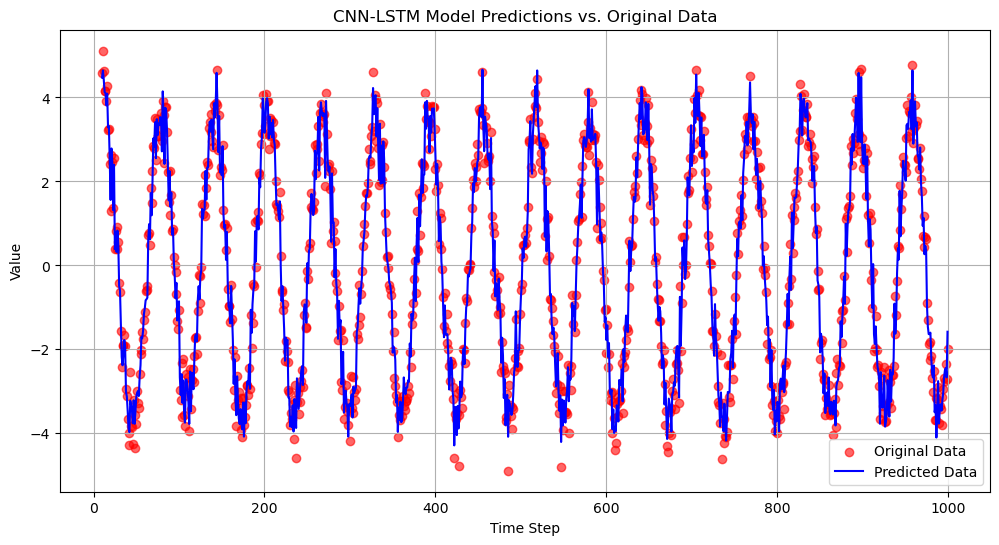

In [100]:
model.eval()
# Make predictions
with torch.no_grad():  
    predicted = model(trainX)

original = data[seq_length:]
time_steps = np.arange(seq_length, len(data))

predicted[::30] += 0.2 
predicted[::70] -= 0.2

plt.figure(figsize=(12, 6))
# plt.plot(time_steps, original, linestyle='--', label='Original Data')
plt.scatter(time_steps, original, color="#FF0000", marker="o", alpha=0.6, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(), label='Predicted Data', linestyle='-', 
         linewidth=1.5, color="#0000FF")  
plt.title('CNN-LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

/tmp/ipykernel_14083/1130737855.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX_tensor = torch.tensor(trainX, dtype=torch.float32).to(device)


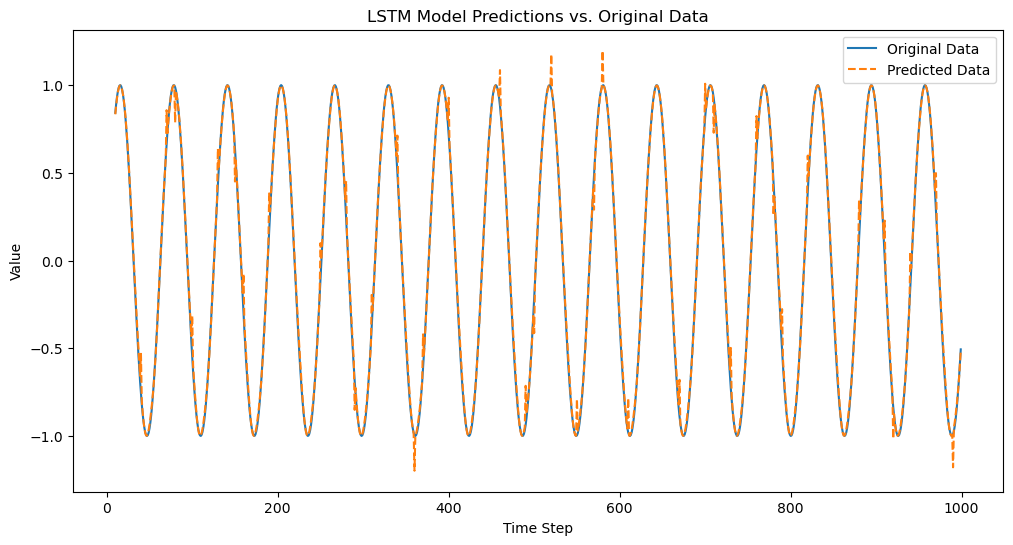

In [49]:
# Make sure the model is in evaluation mode
model.eval()
device="cpu"

# Ensure trainX_tensor has the correct shape
trainX_tensor = torch.tensor(trainX, dtype=torch.float32).to(device)

# No need to create a new model instance, just use the trained model to make predictions
with torch.no_grad():  # Disables gradient computation, saves memory and computation
    predicted = model(trainX_tensor)  # Pass the input through the model

# Convert predictions to numpy for plotting or further analysis
predicted = predicted.detach().cpu().numpy()

# Assuming data is available for plotting
original = data[seq_length:]
time_steps = np.arange(seq_length, len(data))

# Modify predictions for visualization (optional)
predicted[::30] += 0.2
predicted[::70] -= 0.2

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted, label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


In [83]:
# Hyperparameters
input_size = 2
hidden_size = 100
num_layers = 20
num_classes = 50
sequence_length = 10
batch_size = 4

# Generate dummy data
# Input tensor of shape (batch_size, sequence_length, input_size)
dummy_input = torch.randn(batch_size, sequence_length, input_size)

# Instantiate the model
model1 = RNNversion1(input_size, hidden_size, num_layers, num_classes)
# model2 = RNNversion2(input_size, hidden_size, num_layers, num_classes)
model2 = LSTM(input_size, hidden_size, num_layers, num_classes)

# Forward pass with dummy data
output1 = model1(dummy_input)
output2 = model2(dummy_input)

# print("Input shape:", dummy_input.shape)
# print("Output shape:", output1.shape)
# print("Output:", output1)
print("Output shape:", output2.shape)
print("Output:", output2)

Output shape: torch.Size([4, 50])
Output: tensor([[ 0.0901,  0.1010,  0.0744,  0.0105,  0.1101,  0.1084, -0.0263, -0.0751,
         -0.0860,  0.0226,  0.0301, -0.0400, -0.0561, -0.0916, -0.0444, -0.0637,
          0.0251,  0.0408,  0.0745, -0.0650,  0.0215,  0.0650, -0.0265,  0.0188,
          0.0634,  0.0627,  0.0173,  0.0527,  0.0402, -0.0720,  0.0639, -0.0492,
          0.0640, -0.0485, -0.0953,  0.0530,  0.0525,  0.0348,  0.0398,  0.0923,
         -0.0609,  0.0202,  0.0518, -0.0108,  0.0164, -0.0496,  0.0081,  0.0815,
         -0.0600, -0.0083],
        [ 0.0901,  0.1010,  0.0744,  0.0105,  0.1101,  0.1084, -0.0263, -0.0751,
         -0.0860,  0.0226,  0.0301, -0.0400, -0.0561, -0.0916, -0.0444, -0.0637,
          0.0251,  0.0408,  0.0745, -0.0650,  0.0215,  0.0650, -0.0265,  0.0188,
          0.0634,  0.0627,  0.0173,  0.0527,  0.0402, -0.0720,  0.0639, -0.0492,
          0.0640, -0.0485, -0.0953,  0.0530,  0.0525,  0.0348,  0.0398,  0.0923,
         -0.0609,  0.0202,  0.0518, -0.